In [1]:
import ranking_and_selection as rs
import queueing_model as qm
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical_high_N.json') as json_file:
    data_as_is_analytical_high_N = json.load(json_file)

# Opening JSON file
with open('data_10yr.json') as json_file:
    data_10yr = json.load(json_file)    

In [3]:
# Explore range of shelter costs and service time distributions
# print('start at time ' + str(datetime.datetime.now()))

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 90]
service_times = [2]

housing_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_qu_unsh_vs_t = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_qu_unsh_vs_t = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_qu_sh_vs_t = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_qu_sh_vs_t = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_p_q = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_p_q = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_10yr['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_10yr['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_10yr, data_as_is_analytical_high_N, data_10yr['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
        q_unsh_for_shelter_sols = []
        q_unsh_for_housing_sols = []
        q_sh_for_shelter_sols = []
        q_sh_for_housing_sols = []
        p_q_for_housing_sols = []
        p_q_for_shelter_sols = []
        
        for k in range(yrs_dec):
            # Data on avg unsheltered queue over duration of model run
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)

            # Data on unsheltered queue over time for model run
            q = spc.true_outputs_unsh_vs_t[k]
            q_unsh_for_housing_sols.append(q)
            q = spc.true_outputs_unsh_vs_t[k+4]
            q_unsh_for_shelter_sols.append(q)

            # Data on sheltered queue over time for model run
            q = spc.true_outputs_sh_vs_t[k]
            q_sh_for_housing_sols.append(q)
            q = spc.true_outputs_sh_vs_t[k+4]
            q_sh_for_shelter_sols.append(q)

            # Data on probabilities (number in queue)
            p = spc.true_probs_num_q[k]
            p_q_for_housing_sols.append(p)
            p = spc.true_probs_num_q[k+4]
            p_q_for_shelter_sols.append(p)
            
        housing_imprv_all4_obj1[i].append(housing_imprv1)
        shelter_imprv_all4_obj1[i].append(shelter_imprv1)
        housing_imprv_all4_obj1_qu_unsh_vs_t[i].append(q_unsh_for_housing_sols)
        shelter_imprv_all4_obj1_qu_unsh_vs_t[i].append(q_unsh_for_shelter_sols)
        housing_imprv_all4_obj1_qu_sh_vs_t[i].append(q_sh_for_housing_sols)
        shelter_imprv_all4_obj1_qu_sh_vs_t[i].append(q_sh_for_shelter_sols)
        housing_imprv_all4_obj1_p_q[i].append(p_q_for_housing_sols)
        shelter_imprv_all4_obj1_p_q[i].append(p_q_for_shelter_sols)
        
        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

done (0, 0) at time 2024-01-15 16:15:30.842839


#### Visualise objective value of time for given solutions

In [4]:
# Calculate percentiles
decision_yr_to_plot = 0

percentiles_high_housing = [t for t in range(data_10yr['analysis_horizon']*365)]
percentiles_low_housing = [t for t in range(data_10yr['analysis_horizon']*365)]
percentiles_high_shelter = [t for t in range(data_10yr['analysis_horizon']*365)]
percentiles_low_shelter = [t for t in range(data_10yr['analysis_horizon']*365)]

cut_off_high = 0.9
cut_off_low = 0.1

for t in range(data_10yr['analysis_horizon']*365):
    looking_high = True
    looking_low = True
    n = 0
    prob_cumulative = 0
    while looking_high:
        prob_cumulative += housing_imprv_all4_obj1_p_q[0][0][decision_yr_to_plot][n][t]
        if prob_cumulative > cut_off_low:
            if looking_low == True:
                percentiles_low_housing[t] = n
                looking_low = False
        if prob_cumulative > cut_off_high:
            percentiles_high_housing[t] = n
            looking_high = False
        n += 1

for t in range(data_10yr['analysis_horizon']*365):
    looking_high = True
    looking_low = True
    n = 0
    prob_cumulative = 0
    while looking_high:
        prob_cumulative += shelter_imprv_all4_obj1_p_q[0][0][decision_yr_to_plot][n][t]
        if prob_cumulative > cut_off_low:
            if looking_low == True:
                percentiles_low_shelter[t] = n
                looking_low = False
        if prob_cumulative > cut_off_high:
            percentiles_high_shelter[t] = n
            looking_high = False
        n += 1

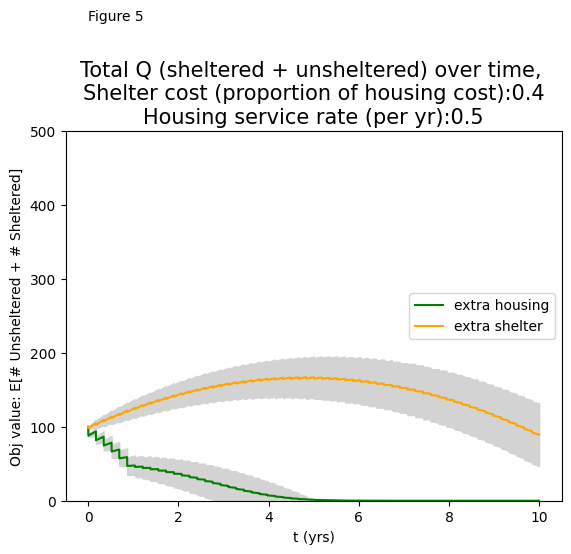

In [5]:
decision_yr_to_plot = 0
title1 = 'Shelter cost (proportion of housing cost):'
title2 = 'Housing service rate (per yr):'
x = [i/365 for i in range(3650)]
y1 = [housing_imprv_all4_obj1_qu_unsh_vs_t[0][0][decision_yr_to_plot][i] + housing_imprv_all4_obj1_qu_sh_vs_t[0][0][decision_yr_to_plot][i] for i in range(3650)]
y2 = [shelter_imprv_all4_obj1_qu_unsh_vs_t[0][0][decision_yr_to_plot][i] + shelter_imprv_all4_obj1_qu_sh_vs_t[0][0][decision_yr_to_plot][i] for i in range(3650)]
n_rw = 1
n_cl = 1
plt.plot(x, y1, color = 'green', label = 'extra housing', markersize = 4)
plt.plot(x, y2, color = 'orange', label = 'extra shelter', markersize = 4)
plt.fill_between(x, percentiles_low_housing, percentiles_high_housing, color = 'lightgrey')
plt.fill_between(x, percentiles_low_shelter, percentiles_high_shelter, color = 'lightgrey')
plt.title('Total Q (sheltered + unsheltered) over time, \n' + 
          title1 + 
          str(round(hx/additional_shelter[0],2)) + 
          '\n' + 
          title2 + 
          str(round(1/service_times[0],2)),fontsize = 15)
plt.xlabel('t (yrs)')
plt.ylabel('Obj value: E[# Unsheltered + # Sheltered]')
plt.ylim(0,500)
plt.text(0, 650, 'Figure 5')
plt.legend(loc = 'center right')
plt.show()